In [1]:
import seaborn as sn
import pandas as pd
import json, os

# import torch
# import torch.nn as nn
# from torch.nn.utils.rnn import pad_sequence
# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from torch.optim import Adam
# from transformers import get_linear_schedule_with_warmup
# from torch.nn.utils import clip_grad_norm_
# from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# from transformers import AutoTokenizer, AutoModel

from transformers import AutoTokenizer, TFAutoModel, TFGPT2LMHeadModel, RobertaTokenizer
from transformers import set_seed

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Embedding, MaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D, Flatten
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from keras_preprocessing.text import tokenizer_from_json
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Layer

import numpy as np
import csv

import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import time
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import random

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from collections import defaultdict
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import shuffle
from tqdm.notebook import tqdm


C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define method name and root path of the repository

In [2]:
method = "embeddingsExtraction"

root_path = os.path.join('..', '..')

In [3]:
embedding_algorithm = "bert" # "bert" # "gpt"

Define specific seeder for all experiments and processes

In [ ]:
seeders = [123456, 789012, 345678, 901234, 567890, 123, 456, 789, 123, 456]

seed = seeders[0]

np.random.seed(seed)
random.seed(seed)
#torch.manual_seed(seed)
tf.random.set_seed(seed)
set_seed(seed)

Read data and shuffle them

In [5]:
dataset = pd.read_csv(os.path.join(root_path, 'data', 'train.csv'))

In [13]:
data = dataset.sample(frac=1, random_state=seed).reset_index(drop=True)
print(data.head())
print(len(data))

    index Access Gained Attack Origin Authentication Required Availability  \
0   82302           NaN        Remote            Not required      Partial   
1   57423           NaN         Local            Not required     Complete   
2   48002           NaN         Local            Not required     Complete   
3   92783           NaN        Remote            Not required      Partial   
4  123879           NaN        Remote            Not required      Partial   

           CVE ID                                        CVE Page   CWE ID  \
0  CVE-2018-11598  https://www.cvedetails.com/cve/CVE-2018-11598/  CWE-125   
1   CVE-2015-8539   https://www.cvedetails.com/cve/CVE-2015-8539/  CWE-264   
2   CVE-2016-9685   https://www.cvedetails.com/cve/CVE-2016-9685/  CWE-400   
3  CVE-2018-20784  https://www.cvedetails.com/cve/CVE-2018-20784/  CWE-400   
4   CVE-2013-0918   https://www.cvedetails.com/cve/CVE-2013-0918/  CWE-264   

  Complexity Confidentiality  ... parentID  \
0     Medium    

In [ ]:
data = data[data["project"] != "Chrome"]
print(len(data))

In [14]:
data = data[["processed_func", "target"]]
data.head()

,processed_func,target
0,bool jspIsInterrupted() {\n return (execInfo....,0
1,void user_destroy(struct key *key)\n{\n\tstruc...,0
2,xfs_attr_leaf_list(xfs_attr_list_context_t *co...,0
3,static inline void update_tg_load_avg(struct c...,0
4,static void NotifyTimezoneChange(WebKit::WebFr...,0


In [15]:
data = data.dropna(subset=["processed_func"])

In [16]:
word_counts = data["processed_func"].apply(lambda x: len(x.split()))
max_length = word_counts.max()
print("Maximum number of words:", max_length)

Maximum number of words: 15441


In [17]:
vc = data["target"].value_counts()

print(vc)

print("Percentage: ", (vc[1] / vc[0])*100, '%')

n_categories = len(vc)
print(n_categories)

target
0    142172
1      8736
Name: count, dtype: int64
Percentage:  6.1446698365360275 %
2


In [18]:
train_data = pd.DataFrame(({'text': data['processed_func'], 'label': data['target']}))
#train_data = train_data[0:100]
train_data.head()

,text,label
0,bool jspIsInterrupted() {\n return (execInfo....,0
1,void user_destroy(struct key *key)\n{\n\tstruc...,0
2,xfs_attr_leaf_list(xfs_attr_list_context_t *co...,0
3,static inline void update_tg_load_avg(struct c...,0
4,static void NotifyTimezoneChange(WebKit::WebFr...,0


Train test split with seeder

In [29]:
val_data = pd.read_csv(os.path.join(root_path, 'data', 'val.csv'))

val_data = val_data[val_data["project"] != "Chrome"]

val_data = pd.DataFrame(({'text': val_data['processed_func'], 'label': val_data['target']}))
val_data.head()

,text,label
0,void PdfCompositorClient::Connect(service_mana...,0
1,int iwlagn_add_bssid_station(struct iwl_priv *...,0
2,"static int dnxhd_init_vlc(DNXHDContext *ctx, u...",0
3,void CameraService::onFirstRef()\n{\n LOG1(...,0
4,int EmbedStream::getChar() {\n if (limited &&...,0


In [30]:
test_data = pd.read_csv(os.path.join(root_path, 'data', 'test.csv'))

test_data = test_data[test_data["project"] != "Chrome"]

test_data = pd.DataFrame(({'text': test_data['processed_func'], 'label': test_data['target']}))

Pre-processing step: Under-sampling

In [21]:
sampling = False
if n_categories == 2 and sampling == True:
    # Apply under-sampling with the specified strategy
    class_counts = pd.Series(train_data["label"]).value_counts()
    print("Class distribution ", class_counts)

    majority_class = class_counts.idxmax()
    print("Majority class ", majority_class)

    minority_class = class_counts.idxmin()
    print("Minority class ", minority_class)

    target_count = 2 * class_counts[class_counts.idxmin()] # class_counts[class_counts.idxmin()] # int(class_counts.iloc[0] / 2) 
    print("Targeted number of majority class", target_count)

    # under
    sampling_strategy = {majority_class: target_count}        
    rus = RandomUnderSampler(random_state=seed, sampling_strategy=sampling_strategy)

    x_train_resampled, y_train_resampled = rus.fit_resample(np.array(train_data["text"]).reshape(-1, 1), train_data["label"]) 
    print("Class distribution after augmentation", pd.Series(y_train_resampled).value_counts())


    # Shuffle the resampled data while preserving the correspondence between features and labels
    x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=seed)

    # rename
    X_train = x_train_resampled
    Y_train = y_train_resampled

    X_train = pd.Series(X_train.reshape(-1))

else:
    X_train = train_data["text"]
    Y_train = train_data["label"]

Choose transformer model

In [13]:
# microsoft/codebert-base-mlm # microsoft/codebert-base

In [14]:
# # PYTORCH
# if embedding_algorithm == "bert":
#     model_variation = "microsoft/codebert-base-mlm"
#     tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
#     #bert-base-uncased #bert-base #albert-base-v2 # roberta-base # distilbert-base-uncased #distilbert-base 
#     # Define New tokens for string and numerical i.e., strId$ and numId$
#     new_tokens = ["strId$", "numId$"]
#     for new_token in new_tokens:
#         if new_token not in tokenizer.get_vocab().keys():
#             tokenizer.add_tokens(new_token)
            
#     bert = AutoModel.from_pretrained(model_variation, num_labels=n_categories)

#     bert.resize_token_embeddings(len(tokenizer))

#     embedding_matrix = bert.embeddings.word_embeddings.weight.detach().cpu().numpy()
    
#     num_words = len(embedding_matrix)
#     print(num_words)
#     dim = len(embedding_matrix[0])
#     print(dim)
    
#     sentences = X_train.tolist()
#     sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="pt").numpy() for sente in sentences] # Tokenize the complete sentences

#     lines_pad_x_train = []
#     for seq in sequences:
#         lines_pad_x_train.append(torch.tensor(seq[0]))
    
#     lines_pad_x_train = pad_sequence(lines_pad_x_train, batch_first=True, padding_value=0)
#     max_len = lines_pad_x_train.size()[1]
    
    
#     sentences = val_data["Input"]
#     sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="pt").numpy() for sente in sentences]
#     lines_pad_x_val = []
#     for seq in sequences:
#         lines_pad_x_val.append(torch.tensor(seq[0]))
#     lines_pad_x_val = pad_sequence(lines_pad_x_val, batch_first=True, padding_value=0)
    
#     sentences = test_data["Input"]
#     sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="pt").numpy() for sente in sentences]
#     lines_pad_x_test = []
#     for seq in sequences:
#         lines_pad_x_test.append(torch.tensor(seq[0]))
#     lines_pad_x_test = pad_sequence(lines_pad_x_test, batch_first=True, padding_value=0)
    

In [22]:
def getMaxLen(X):

    # Code for identifying max length of the data samples after tokenization using transformer tokenizer
    
    max_length = 0
    # Iterate over each sample in your dataset
    for i, input_ids in enumerate(X['input_ids']):
        # Calculate the length of the tokenized sequence for the current sample
        length = tf.math.reduce_sum(tf.cast(input_ids != 1, tf.int32)).numpy()
        # Update max_length and max_row if the current length is greater
        if length > max_length:
            max_length = length
            max_row = i

    print("Max length of tokenized data:", max_length)
    print("Row with max length:", max_row)

    #X['input_ids'] = np.delete(X['input_ids'], max_row, axis=0)
    
    return max_length

In [23]:
# TENSORFLOW
if embedding_algorithm == "bert":
    model_variation = "microsoft/codebert-base-mlm"
#     model_variation = "microsoft/codebert-base"
#     tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
    tokenizer = RobertaTokenizer(vocab_file="../tokenizer_training/cpp_tokenizer/cpp_tokenizer-vocab.json",
                             merges_file="../tokenizer_training/cpp_tokenizer/cpp_tokenizer-merges.txt")
    #bert-base-uncased #bert-base #albert-base-v2 # roberta-base # distilbert-base-uncased #distilbert-base 
    # Define New tokens for string and numerical i.e., strId$ and numId$
#     new_tokens = ["strId$", "numId$"]
#     for new_token in new_tokens:
#         if new_token not in tokenizer.get_vocab().keys():
#             tokenizer.add_tokens(new_token)
            
    bert = TFAutoModel.from_pretrained(model_variation)

    #bert.resize_token_embeddings(len(tokenizer))
    
    bert_embeddings = bert.get_input_embeddings()
    embedding_matrix = bert_embeddings.weights[0].numpy()
    
    num_words = embedding_matrix.shape[0]
    print(num_words)
    dim = embedding_matrix.shape[1]
    print(dim)
    
    sentences = X_train.tolist()
    sequences = [tokenizer(sente, truncation=True, max_length=510, add_special_tokens=False, return_tensors="tf") for sente in sentences] # Tokenize the complete sentences

    def padSequences(sequences, max_len):
        lines_pad = []
        for sequence in sequences:
            seq = sequence['input_ids'].numpy()[0]
            if len(seq) < max_len:
                for i in range(len(seq), max_len):
                    seq = np.append(seq, 0)
            lines_pad.append(seq)
        return lines_pad
    
    def get_max_len(sequences):
        max_len = 0

        for seq in sequences:
            if len(seq['input_ids'].numpy()[0]) > max_len:
                max_len = len(seq['input_ids'].numpy()[0])

        return max_len
    
    max_len = get_max_len(sequences)
    print(max_len)
    
    lines_pad_x_train = padSequences(sequences, max_len)
    lines_pad_x_train = [arr.tolist() for arr in lines_pad_x_train]
    lines_pad_x_train = np.array(lines_pad_x_train)
        
    val_sentences = val_data["text"].tolist()
    val_sequences = [tokenizer(sente, truncation=True, max_length=510, add_special_tokens=False, return_tensors="tf") for sente in val_sentences]
    
    lines_pad_x_val = padSequences(val_sequences, max_len)
    lines_pad_x_val = [arr.tolist() for arr in lines_pad_x_val]
    lines_pad_x_val = np.array(lines_pad_x_val)
    
    test_sentences = test_data["text"].tolist()
    test_sequences = [tokenizer(sente, truncation=True, max_length=510, add_special_tokens=False, return_tensors="tf") for sente in test_sentences]
    
    lines_pad_x_test = padSequences(test_sequences, max_len)
    lines_pad_x_test = [arr.tolist() for arr in lines_pad_x_test]
    lines_pad_x_test = np.array(lines_pad_x_test)
    

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at microsoft/codebert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


50265
768
510


KeyError: 'text'

In [ ]:
# # PYTORCH
# if embedding_algorithm == "gpt":
#     model_variation = "gpt2" # "microsoft/CodeGPT-small-py-adaptedGPT2" # "gpt2" # "microsoft/CodeGPT-small-py" 
#     tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
#     # Define New tokens for string and numerical i.e., strId$ and numId$
#     new_tokens = ["strId$", "numId$"]
#     for new_token in new_tokens:
#         if new_token not in tokenizer.get_vocab().keys():
#             tokenizer.add_tokens(new_token)
            
#     gpt = AutoModel.from_pretrained(model_variation, num_labels=n_categories)

#     gpt.resize_token_embeddings(len(tokenizer))

#     embedding_matrix = gpt.wte.weight.detach().cpu().numpy()
    
#     num_words = len(embedding_matrix)
#     print(num_words)
#     dim = len(embedding_matrix[0])
#     print(dim)
    
#     sentences = X_train.tolist()
#     sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="pt").numpy() for sente in sentences] # Tokenize the complete sentences

#     lines_pad_x_train = []
#     for seq in sequences:
#         lines_pad_x_train.append(torch.tensor(seq[0]))
    
#     lines_pad_x_train = pad_sequence(lines_pad_x_train, batch_first=True, padding_value=0)
#     max_len = lines_pad_x_train.size()[1]
    
    
#     sentences = val_data["Input"]
#     sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="pt").numpy() for sente in sentences]
#     lines_pad_x_val = []
#     for seq in sequences:
#         lines_pad_x_val.append(torch.tensor(seq[0]))
#     lines_pad_x_val = pad_sequence(lines_pad_x_val, batch_first=True, padding_value=0)
    
#     sentences = test_data["Input"]
#     sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="pt").numpy() for sente in sentences]
#     lines_pad_x_test = []
#     for seq in sequences:
#         lines_pad_x_test.append(torch.tensor(seq[0]))
#     lines_pad_x_test = pad_sequence(lines_pad_x_test, batch_first=True, padding_value=0)
    

In [ ]:
# TENSORFLOW
if embedding_algorithm == "gpt":
    model_variation = "gpt2" # "microsoft/CodeGPT-small-py-adaptedGPT2" # "gpt2" # "microsoft/CodeGPT-small-py"
    tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
    #bert-base-uncased #bert-base #albert-base-v2 # roberta-base # distilbert-base-uncased #distilbert-base 
    # Define New tokens for string and numerical i.e., strId$ and numId$
#     new_tokens = ["strId$", "numId$"]
#     for new_token in new_tokens:
#         if new_token not in tokenizer.get_vocab().keys():
#             tokenizer.add_tokens(new_token)
            
    gpt = TFGPT2LMHeadModel.from_pretrained(model_variation, num_labels=n_categories)

    #gpt.resize_token_embeddings(len(tokenizer))
    
    embedding_matrix = gpt.transformer.wte.weight
    
    num_words = embedding_matrix.shape[0]
    print(num_words)
    dim = embedding_matrix.shape[1]
    print(dim)
    
#     X = tokenizer(
#         text=X_train.tolist(),
#         add_special_tokens=False,
#         max_length=512,
#         truncation=True,
#         padding=True,
#         return_tensors='tf',
#         return_token_type_ids=False,
#         return_attention_mask=True,
#         verbose=True
#     )

#     max_len = getMaxLen(X)
    max_len = 512
    
    sentences = X_train.tolist()
    sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="tf").numpy() for sente in sentences] # Tokenize the complete sentences

    lines_pad_x_train = []
    for seq in sequences:
        lines_pad_x_train.append(seq[0])
    
    lines_pad_x_train = pad_sequences(lines_pad_x_train, padding = 'post', maxlen = max_len)    
    
    sentences = val_data["text"].tolist()
    sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="tf").numpy() for sente in sentences]
    lines_pad_x_val = []
    for seq in sequences:
        lines_pad_x_val.append(seq[0])
    lines_pad_x_val = pad_sequences(lines_pad_x_val, padding = 'post', maxlen = max_len)
    
    sentences = test_data["text"].tolist()
    sequences = [tokenizer.encode(sente, truncation=True, add_special_tokens=False, return_tensors="tf").numpy() for sente in sentences]
    lines_pad_x_test = []
    for seq in sequences:
        lines_pad_x_test.append(seq[0])
    lines_pad_x_test = pad_sequences(lines_pad_x_test, padding = 'post', maxlen = max_len)

    embedding_matrix = embedding_matrix.numpy()

In [32]:
Y_train = np.array(Y_train)
Y_val = np.array(val_data["label"])
Y_test = np.array(test_data["label"])
len(Y_train), len(Y_val), len(Y_test)

(150908, 18864, 18864)

In [33]:
# Evaluation functions
def recall_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

def precision_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

def f1_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f1 = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f1

def f2_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f2 = 5*((prec*rec)/(4*prec+rec+K.epsilon()))
    return f2

Select Hyper-parameters

In [34]:
n_epochs = 100
patience = 10
batch_size = 64
lr = 0.001
optimizer = optimizers.Adam(learning_rate=lr)

In [35]:
# Deep Learning Models - Classifiers
def buildLstm(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    model=Sequential()
    kernel_initializer = glorot_uniform() # glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(LSTM(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer)) # , recurrent_constraint=max_norm(3)
    model.add(LSTM(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    model.add(LSTM(200, activation='tanh', dropout=0.1, stateful=False, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization()) # default momentum=0.99
    #model.add(Dropout(0.2))
    
    #optimizer = optimizers.SGD(lr=learning_rate, decay=0.1, momentum=0.2, nesterov=True)
    #optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-8, decay=0.0)
    #optimizer = optimizers.Adagrad(lr=learning_rate, epsilon=None, decay=0.004)
    #optimizer = optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    
    if n_categories > 2:
        model.add(Dense(units = n_categories, activation = 'softmax', kernel_initializer=kernel_initializer))
        model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer=kernel_initializer))
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f1_metric])
    return model

def buildGru(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    model=Sequential()
    kernel_initializer = glorot_uniform() # glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(GRU(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer)) # , recurrent_constraint=max_norm(3)
    model.add(GRU(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    model.add(GRU(200, activation='tanh', dropout=0.1, stateful=False, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization()) # default momentum=0.99
    #model.add(Dropout(0.2))
    
    #optimizer = optimizers.SGD(lr=learning_rate, decay=0.1, momentum=0.2, nesterov=True)
    #optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-8, decay=0.0)
    #optimizer = optimizers.Adagrad(lr=learning_rate, epsilon=None, decay=0.004)
    #optimizer = optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    
    if n_categories > 2:
        model.add(Dense(units = n_categories, activation = 'softmax', kernel_initializer=kernel_initializer))
        model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer=kernel_initializer))
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f1_metric]) 
    return model

def buildBiLstm(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    model=Sequential()
    kernel_initializer = glorot_uniform() # glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(Bidirectional(LSTM(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer))) # , recurrent_constraint=max_norm(3)
    model.add(Bidirectional(LSTM(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer)))
    model.add(Bidirectional(LSTM(200, activation='tanh', dropout=0.1, stateful=False, kernel_initializer=kernel_initializer)))
    model.add(BatchNormalization()) # default momentum=0.99
    #model.add(Dropout(0.2))
    
    #optimizer = optimizers.SGD(lr=learning_rate, decay=0.1, momentum=0.2, nesterov=True)
    #optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-8, decay=0.0)
    #optimizer = optimizers.Adagrad(lr=learning_rate, epsilon=None, decay=0.004)
    #optimizer = optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    
    if n_categories > 2:
        model.add(Dense(units = n_categories, activation = 'softmax', kernel_initializer=kernel_initializer))
        model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer=kernel_initializer))
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f1_metric]) 
    return model

def buildBiGru(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    model=Sequential()
    kernel_initializer = glorot_uniform() # glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(Bidirectional(GRU(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer))) # , recurrent_constraint=max_norm(3)
    model.add(Bidirectional(GRU(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer)))
    model.add(Bidirectional(GRU(200, activation='tanh', dropout=0.1, stateful=False, kernel_initializer=kernel_initializer)))
    model.add(BatchNormalization()) # default momentum=0.99
    #model.add(Dropout(0.2))
    
    #optimizer = optimizers.SGD(lr=learning_rate, decay=0.1, momentum=0.2, nesterov=True)
    #optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-8, decay=0.0)
    #optimizer = optimizers.Adagrad(lr=learning_rate, epsilon=None, decay=0.004)
    #optimizer = optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    
    if n_categories > 2:
        model.add(Dense(units = n_categories, activation = 'softmax', kernel_initializer=kernel_initializer))
        model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer=kernel_initializer))
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f1_metric])  
    return model

def buildCnn(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    cnn_model = Sequential()
    cnn_model.add(Embedding(top_words, dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
    '''cnn_model.add(MaxPooling1D(pool_size = 5))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
    cnn_model.add(MaxPooling1D(pool_size = 5))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))'''
    cnn_model.add(GlobalMaxPool1D())
    #cnn_model.add(Dense(units = 128, activation = 'relu'))
    
    if n_categories > 2:
        cnn_model.add(Dense(units = n_categories, activation = 'softmax'))
        cnn_model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        cnn_model.add(Dense(units = 1, activation = 'sigmoid'))
        cnn_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f1_metric])
    return cnn_model


In [36]:
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

userModel = "gru"

if userModel == "cnn":
    myModel = buildCnn(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories) 
elif userModel == "lstm":
    myModel = buildLstm(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories)
elif userModel == "bilstm":
    myModel = buildBiLstm(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories)
elif userModel == "gru":
    myModel = buildGru(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories)
elif userModel == "bigru":
    myModel = buildBiGru(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories)
    
print("model summary\m", myModel.summary())

csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_f1_metric', mode='max', verbose=1, patience=patience)
mc = ModelCheckpoint('best_model.h5', monitor='val_f1_metric', mode='max', verbose=1, save_best_only=True)

history = myModel.fit(lines_pad_x_train, Y_train, validation_data=(lines_pad_x_val, Y_val), epochs = n_epochs, batch_size = batch_size, shuffle=False, verbose=1, callbacks=[csv_logger,es,mc]) #, class_weight=class_weights

milli_sec2 = int(round(time.time() * 1000))
print("Training is completed after", milli_sec2-milli_sec1)


Training...


C:\Users\iliaskaloup\AppData\Local\anaconda3\envs\tfenv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 768)         38603520  
                                                                 
 gru (GRU)                   (None, None, 500)         1905000   
                                                                 
 gru_1 (GRU)                 (None, None, 100)         180600    
                                                                 
 gru_2 (GRU)                 (None, 200)               181200    
                                                                 
 batch_normalization (BatchN  (None, 200)              800       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                        

KeyboardInterrupt: 

Load best model

In [37]:
#model = load_model('best_model.h5')
myModel.load_weights("best_model.h5")

Classification report on validation set

In [38]:
print(classification_report(Y_val, (myModel.predict(lines_pad_x_val) > 0.5).astype("int32")))

590/590 [==============================] - 41s 64ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17755
           1       0.97      0.86      0.91      1109

    accuracy                           0.99     18864
   macro avg       0.98      0.93      0.95     18864
weighted avg       0.99      0.99      0.99     18864



Prediction and Evaluation on testing set

590/590 [==============================] - 38s 64ms/step
TP= 924
TN= 17778
FP= 31
FN= 131
Accuracy:99.14%
Precision:96.75%
Recall:87.58%
F1 score:91.94%
Roc_Auc score:93.70%
F2 score:89.28%
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     17809
           1       0.97      0.88      0.92      1055

    accuracy                           0.99     18864
   macro avg       0.98      0.94      0.96     18864
weighted avg       0.99      0.99      0.99     18864



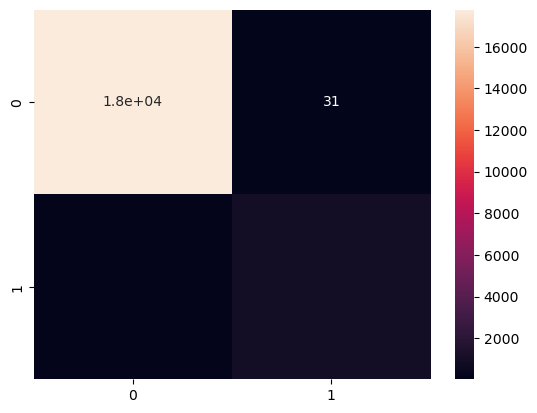

In [39]:
#scores = myModel.evaluate(lines_pad_x_test, Y_test, verbose=0)
#predictions = myModel.predict_classes(X_test, verbose=0)
predScores = myModel.predict(lines_pad_x_test)
predictions = (predScores > 0.5).astype("int32")

accuracy=accuracy_score(Y_test, predictions)
if n_categories > 2:
    precision=precision_score(Y_test, predictions, average='macro')
    recall=recall_score(Y_test, predictions, average='macro')
    f1=f1_score(Y_test, predictions, average='macro')
else:
    precision=precision_score(Y_test, predictions)
    recall=recall_score(Y_test, predictions)
    f1=f1_score(Y_test, predictions)
    roc_auc=roc_auc_score(Y_test, predictions)
f2=5*precision*recall / (4*precision+recall)

cm = confusion_matrix(Y_test, predictions)
#print(cm)
sn.heatmap(cm, annot=True)
tn, fp, fn, tp = cm.ravel()

print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)

acc = ((tp+tn)/(tp+tn+fp+fn))

print("Accuracy:%.2f%%"%(acc*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("F1 score:%.2f%%"%(f1*100))
print("Roc_Auc score:%.2f%%"%(roc_auc*100))
print("F2 score:%.2f%%"%(f2*100))
print(classification_report(Y_test, predictions))

Export classification report

In [ ]:
# Create the path
path = os.path.join(root_path, 'results', model_variation.split("/")[-1], method, str(seed))

# Create directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Define the CSV file path
csv_file_path = os.path.join(path, f"{seed}.csv")

# Write data to CSV
data = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "f2": f2,
    "roc_auc": roc_auc
}

# Write to CSV
with open(csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=data.keys())
    writer.writeheader()
    writer.writerow(data)


Compute the average values of the classication metrics considering the results for all different seeders

In [ ]:
# Define a dictionary to store cumulative sum of metrics
cumulative_metrics = defaultdict(float)
count = 0  # Counter to keep track of number of CSV files

# Iterate over all CSV files in the results folder
results_folder = os.path.join(root_path, "results", model_variation.split("/")[-1], method, str(seed))
for filename in os.listdir(results_folder):
    if filename.endswith(".csv"):
        csv_file_path = os.path.join(results_folder, filename)
        with open(csv_file_path, "r", newline="") as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                for metric, value in row.items():
                    cumulative_metrics[metric] += float(value)
        count += 1
        
# Compute average values
average_metrics = {metric: total / count for metric, total in cumulative_metrics.items()}

# Print average values 
print(average_metrics)

# Define the path for the average CSV file
avg_csv_file_path = os.path.join(root_path, "results", model_variation.split("/")[-1], method, "avg.csv")

# Write average metrics to CSV
with open(avg_csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=average_metrics.keys())
    writer.writeheader()
    writer.writerow(average_metrics)